In [84]:
import os
import cv2
import numpy as np
import tensorflow as tf  # Make sure TensorFlow is installed

# Define the path to the main directory
base_dir = 'data'

# Initialize lists to store paired data
input_images = []
ground_truth_images = []

# Specify the target size for resizing images
target_size = (200, 200)  # You can change this to the desired dimensions

# Iterate through each pair directory
for pair_dir in sorted(os.listdir(base_dir)):
    pair_path = os.path.join(base_dir, pair_dir)
    
    # Check if it's a directory
    if os.path.isdir(pair_path):
        # Get the Input and Ground-Truth image filenames
        ground_truth_image_filename = [f for f in os.listdir(pair_path) if 'gt' in f.lower()][0]  # Assuming GT images have 'gt' in their filename
        input_image_filename = [f for f in os.listdir(pair_path) if 'input' in f.lower()][0]  # Assuming Input images have 'input' in their filename
        
        # Construct full paths for the images
        ground_truth_image_path = os.path.join(pair_path, ground_truth_image_filename)
        input_image_path = os.path.join(pair_path, input_image_filename)
        
        # Read images
        ground_truth_image = cv2.imread(ground_truth_image_path, cv2.IMREAD_COLOR)  # Ground-truth as grayscale
        input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Input as color

        # Resize images to the target size
        ground_truth_image = cv2.resize(ground_truth_image, target_size)
        input_image = cv2.resize(input_image, target_size)

        # Normalize and preprocess images
        ground_truth_image = ground_truth_image / 255.0  # Normalize to [0,1]
        input_image = input_image / 255.0  # Normalize input image to [0,1]
        
        # Store Input and Ground-Truth images
        input_images.append(input_image)
        ground_truth_images.append(ground_truth_image)

# Convert lists to numpy arrays for easy batch processing
input_images = np.array(input_images)
ground_truth_images = np.array(ground_truth_images)

print("Loaded Input and Ground-Truth image pairs successfully.")
print(f"Input Images Tensor Shape: {input_images.shape}")
print(f"Ground-Truth Images Tensor Shape: {ground_truth_images.shape}")


Loaded Input and Ground-Truth image pairs successfully.
Input Images Tensor Shape: (8, 200, 200)
Ground-Truth Images Tensor Shape: (8, 200, 200, 3)


In [85]:
# Convert inPUT to have three channels
input_images = np.stack((input_images,) * 3, axis=-1)  # Shape: (num_samples, 200, 200, 3)

(200, 200, 3)

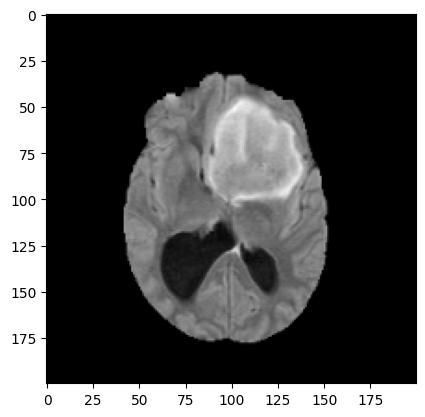

In [86]:
import matplotlib.pyplot as plt
img_in = input_images[0]
#img = cv2.cvtColor(img,cv2.Grey)

#img = cv2.resize(img, (224, 224))
plt.imshow(img_in)
img_in.shape

(200, 200, 3)

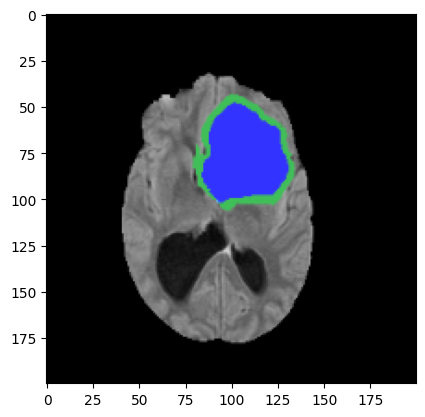

In [87]:
img_gt = ground_truth_images[0]
#img_gt= cv2.applyColorMap((img_gt * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply a colormap

#img_gt = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

#img = cv2.resize(img, (224, 224))
#plt.axis('off')
plt.imshow(img_gt)
img_gt.shape

# ResUnet Architecture

In [88]:
# import keras modules and its important APIs

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as k
from keras.models import Model
#from keras datasets import cifar10
import numpy as np
import os

In [89]:
from tensorflow.keras.layers import Add, Input, Conv2D, BatchNormalization, LeakyReLU, UpSampling2D,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D

In [90]:
def d_block(inputs, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    return x

In [91]:
def bridge_block(inputs, num_filters):
    x = BatchNormalization()(inputs)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    return x

In [92]:
def initial_block(inputs,num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same',kernel_initializer='he_normal')(inputs)
    #x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(inputs)
    x = LeakyReLU()(x)
    return x

In [93]:
def u_block(inputs, skip_connection, num_filters):
   # x = UpSampling2D(size=(2, 2))(inputs)
    x=inputs
    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Concatenate with the skip connection
    """if x.shape[1:] != skip_connection.shape[1:]:
        skip_connection = UpSampling2D(size=(2, 2))(skip_connection)"""
    x = Concatenate()([x, skip_connection])

    x = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

In [94]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
def ResUNet(input_shape,gt_shape):
    # Define inputs for SAR and Optical images
    
    input_shape=Input(shape=input_shape) # e.g., (height, width, channels)
    gt_shape= Input(shape=gt_shape)
    
    # Encoding path for SAR input
    #d0_sar=initial_block(sar_input,num_filters=8)
    d1_input = d_block(input_shape, num_filters=16)
    print("Shape after d1_input:", d1_input.shape)

    d2_input= d_block(d1_input, num_filters=32)
    print("Shape after d2_input:", d2_input.shape)

    d3_input= d_block(d2_input, num_filters=64)
    print("Shape after d3_input:", d3_input.shape)

    # Repeat this for optical input


    # Encoding path for Optical input
    #d0_optical = d_block(optical_input, num_filters=8)
    d1_gt = d_block(gt_shape, num_filters=16)
    print("Shape after d1_gt:", d1_gt.shape)
    d2_gt = d_block(d1_gt, num_filters=32)
    print("Shape after d2_gt:", d1_gt.shape)
    d3_gt = d_block(d2_gt, num_filters=64)
    print("Shape after d3_gt:", d1_gt.shape)
    #d3_optical = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(d2_optical)
    #combine features from both paths - cancatenate
    combined = Add()([d3_input, d3_gt]) #or concatenate -##[1733,2500,64]
    print("Shape after combined:", combined.shape)
    
    # Bridge
    bridge = bridge_block(combined, num_filters=128) ##[1733,2500,128]
    print("Shape after bridge:", bridge.shape)
    # Decoding path (Upsampling)
    u1 = u_block(bridge, d3_input, num_filters=64)  # Use skip connection from SAR
    print("Shape after u1:", u1.shape)
    u2 = u_block(u1, d2_input, num_filters=32)      # Use skip connection from SAR
    print("Shape after u2:", u2.shape)
    u3 = u_block(u2, d1_input, num_filters=16)      # Use skip connection from SAR
    print("Shape after u3:", u3.shape)
    #u4 = u_block(u3, d0_sar, num_filters=8)      # Use skip connection from SAR
    # Output layer
    outputs = Conv2D(3, kernel_size=1, activation='tanh')(u3)
    model = Model(inputs=[input_shape, gt_shape], outputs=outputs)
    model.summary()
    return model

In [95]:
import numpy as np

# Assuming you have input_images and ground_truth_images as your dataset
input_images = np.array(input_images)  # Shape: (num_samples, height, width, channels)
ground_truth_images = np.array(ground_truth_images)  # Shape: (num_samples, height, width)

# Set the random seed for reproducibility
np.random.seed(42)

# Shuffle the dataset
indices = np.arange(input_images.shape[0])
np.random.shuffle(indices)

# Shuffle the images
input_images = input_images[indices]
ground_truth_images = ground_truth_images[indices]

# Define the split sizes
train_size = int(0.7 * input_images.shape[0])  # 70% for training
val_size = int(0.15 * input_images.shape[0])   # 15% for validation
test_size = input_images.shape[0] - train_size - val_size  # Remaining for testing

# Split the dataset
X_train, X_val, X_test = input_images[:train_size], input_images[train_size:train_size + val_size], input_images[train_size + val_size:]
y_train, y_val, y_test = ground_truth_images[:train_size], ground_truth_images[train_size:train_size + val_size], ground_truth_images[train_size + val_size:]

print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')


Training set: (5, 200, 200, 3), Validation set: (1, 200, 200, 3), Test set: (2, 200, 200, 3)


In [96]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#batch_size=10
#setting Training Hyperparameters
batch_size= 1
epochs=1500
data_augmentation=True
# Update your checkpoint to use 'val_accuracy'
checkpoint = ModelCheckpoint("REs_UNet.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# Update early stopping to monitor 'val_accuracy' with mode='max'
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max')

# Ensure your steps_per_epoch and validation_steps are set appropriately
steps_per_epoch = len(input_images) // batch_size  # Adjust based on your data
validation_steps = len(X_test) // batch_size   # Adjust based on your data


In [97]:
input_shape=[200, 200, 3]
gt_shape=[200, 200,3]
model=ResUNet(input_shape,gt_shape) 
# Define the input shape
opt = Adam(learning_rate=0.00001)

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
# Now you can fit your model
history = model.fit(
    x=[X_train, y_train],            # Training inputs
    y=y_train,                          # Training targets
    validation_data=([X_val, y_val], y_val),  # Validation data
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early]
)

# Evaluate your model on the test data
# model.evaluate([test_sar, test_optical], test_optical)

Shape after d1_input: (None, 200, 200, 16)
Shape after d2_input: (None, 200, 200, 32)
Shape after d3_input: (None, 200, 200, 64)
Shape after d1_gt: (None, 200, 200, 16)
Shape after d2_gt: (None, 200, 200, 16)
Shape after d3_gt: (None, 200, 200, 16)
Shape after combined: (None, 200, 200, 64)
Shape after bridge: (None, 200, 200, 128)
Shape after u1: (None, 200, 200, 64)
Shape after u2: (None, 200, 200, 32)
Shape after u3: (None, 200, 200, 16)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 200, 200,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 200, 200,  │        448 │ input_layer_15[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │         64 │ conv2d_109[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │         64 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_108     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_114     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 200, 200,  │      2,320 │ leaky_re_lu_108[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 200, 200,  │      2,320 │ leaky_re_lu_114[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │         64 │ conv2d_110[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │         64 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_109     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_115     │ (None, 200, 200,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 200, 200,  │      4,640 │ leaky_re_lu_109[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 200, 200,  │      4,640 │ leaky_re_lu_115[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        128 │ conv2d_111[0][0]

 Total params: 415,283 (1.58 MB)

 Trainable params: 413,555 (1.58 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/1500


/home/reshni/py3_env/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_358', 'keras_tensor_359']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5/8 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.0490 - loss: 0.2022 
Epoch 1: val_accuracy improved from -inf to 0.01790, saving model to REs_UNet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.0473 - loss: 0.1773 - val_accuracy: 0.0179 - val_loss: 0.0993
Epoch 2/1500
5/8 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.0538 - loss: 0.1050 
Epoch 2: val_accuracy improved from 0.01790 to 0.03730, saving model to REs_UNet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0457 - loss: 0.0958 - val_accuracy: 0.0373 - val_loss: 0.2549
Epoch 3/1500
5/8 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2391 - loss: 0.0856 
Epoch 3: val_accuracy did not improve from 0.03730
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2124 - loss: 0.0786 - val_accuracy: 0.0140 - val_loss: 0.1146
Epoch 4/1500
5/8 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0679 - loss: 0.0734
Epoch 4: val_accuracy improved from 0.03730 to 0.06230, saving model to REs_UNet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2

2024-11-02 00:59:12.638012: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 20: val_accuracy did not improve from 0.82355
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1912 - loss: 0.0106 - val_accuracy: 0.7975 - val_loss: 0.0300
Epoch 21/1500
5/8 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3285 - loss: 0.0088
Epoch 21: val_accuracy improved from 0.82355 to 0.86558, saving model to REs_UNet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2964 - loss: 0.0083 - val_accuracy: 0.8656 - val_loss: 0.0328
Epoch 22/1500
5/8 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2522 - loss: 0.0073
Epoch 22: val_accuracy did not improve from 0.86558
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2495 - loss: 0.0070 - val_accuracy: 0.8171 - val_loss: 0.0305
Epoch 23/1500
5/8 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4441 - loss: 0.0070
Epoch 23: val_accuracy improved from 0.86558 to 0.87580, saving model to REs_UNet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3666 - loss: 0.0066 - val_accuracy: 0.8758 - val_loss: 0.0297
Epoch 24/1500

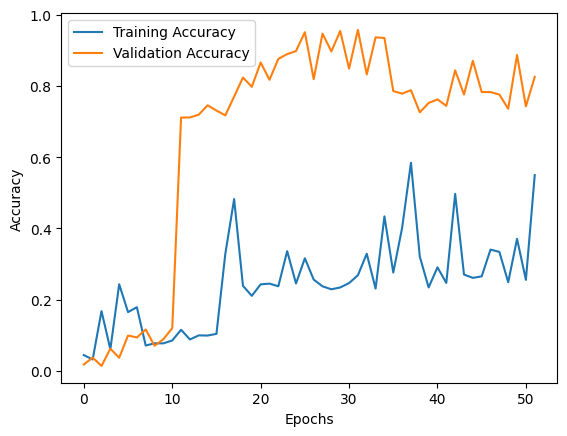

In [98]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Use 'val_accuracy' here
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


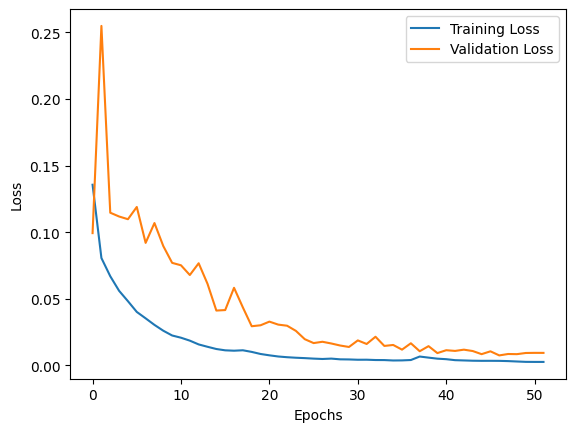

In [100]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # Use 'val_loss' here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()import cv2
import numpy as np
import matplotlib.pyplot as plt

# Display the SAR input image
img_sar = np.array(test_sar[0])
img_sar = cv2.cvtColor(img_sar, cv2.COLOR_BGR2RGB)
plt.imshow(img_sar)
plt.title("Input SAR Image")
plt.show()

# Display the Optical input image
img_optical = np.array(test_optical[0])
img_optical = cv2.cvtColor(img_optical, cv2.COLOR_BGR2HSV)
plt.imshow(img_optical)
plt.title("Input Optical Image")
plt.show()

# Expand dimensions for SAR and Optical images to add batch dimension
sar_input = np.expand_dims(test_sar[0], axis=0)
optical_input = np.expand_dims(test_optical[0], axis=0)

# Predict the output using both SAR and Optical images as inputs
y_pred = model.predict([sar_input, optical_input])

# Display the predicted image (assumed to be similar to optical image)
img_pred = np.array(y_pred[0])
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2HSV)
plt.imshow(img_pred)
plt.title("Predicted Optical Image")
plt.show()


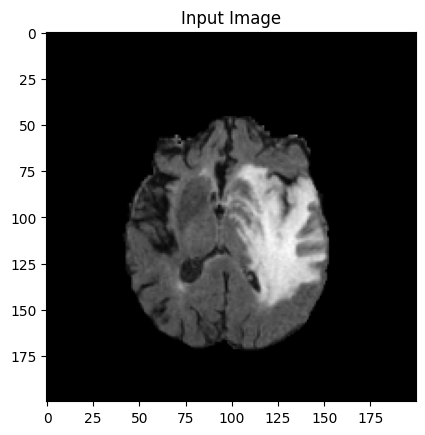

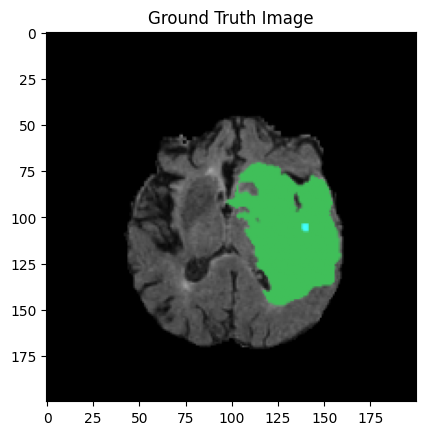

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20352477..0.725369].


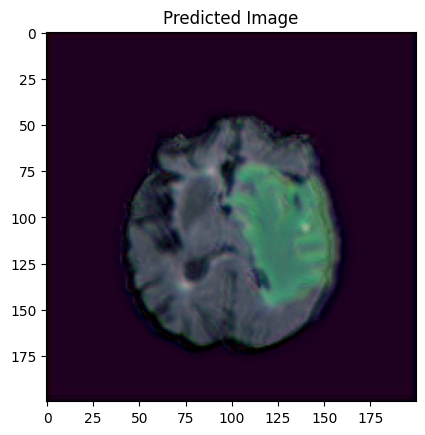

In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Display the input image
img_in = np.array(X_test[0])
#img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
plt.imshow(img_in)
plt.title("Input Image")
plt.show()

# Display the Optical input image
img_gt = np.array(y_test[0])
#img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
plt.imshow(img_gt)
plt.title("Ground Truth Image")
plt.show()

# Expand dimensions for SAR and Optical images to add batch dimension
input_ = np.expand_dims(X_test[0], axis=0)
gt_ = np.expand_dims(y_test[0], axis=0)

# Predict the output using both SAR and Optical images as inputs
y_pred = model.predict([input_, gt_])

# Display the predicted image (assumed to be similar to optical image)
img_pred = np.array(y_pred[0])
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
plt.imshow(img_pred)
plt.title("Predicted Image")
plt.show()


In [105]:
from tensorflow.keras.models import load_model

model = load_model('REs_UNet.keras')

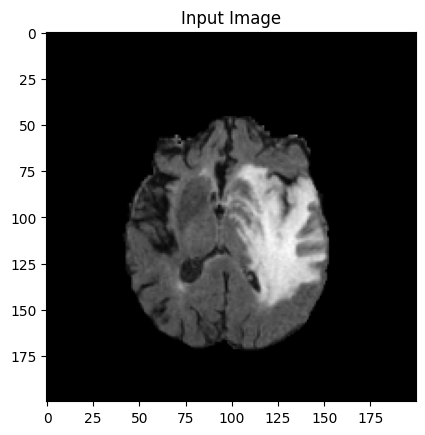

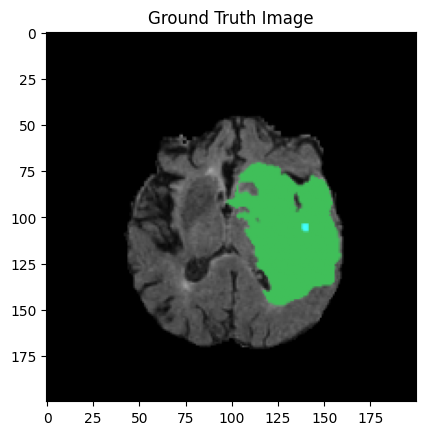

/home/reshni/py3_env/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_14', 'input_layer_15']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22566022..0.78989863].


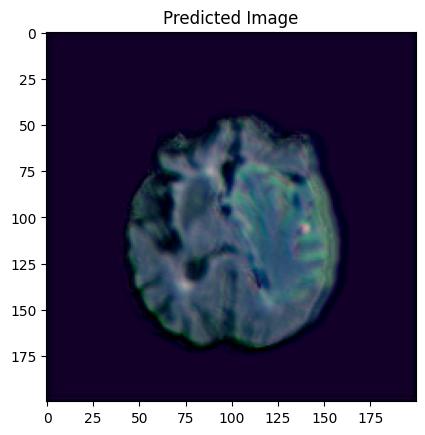

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Display the input image
img_in = np.array(X_test[0])
#img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
plt.imshow(img_in)
plt.title("Input Image")
plt.show()

# Display the Optical input image
img_gt = np.array(y_test[0])
#img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
plt.imshow(img_gt)
plt.title("Ground Truth Image")
plt.show()

# Expand dimensions for SAR and Optical images to add batch dimension
input_ = np.expand_dims(X_test[0], axis=0)
gt_ = np.expand_dims(y_test[0], axis=0)

# Predict the output using both SAR and Optical images as inputs
y_pred = model.predict([input_, gt_])

# Display the predicted image (assumed to be similar to optical image)
img_pred = np.array(y_pred[0])
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
plt.imshow(img_pred)
plt.title("Predicted Image")
plt.show()